### `---------------Mandatory Information to fill------------`

### Group ID:
### Group Members Name with Student ID:
1. Student 1
2. Student 2
3. Student 3
4. Student 4


`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks: ##Add here

## Objective:
Develop and compare Reinforcement Learning agents (DQN and Actor-Critic) to optimize traffic flow and vehicle speed regulation. Implement RL-based strategies to enhance traffic efficiency, reduce congestion, and improve safety by adaptively controlling the speed and lane changes of a selected vehicle within the simulated environment.




## Dataset:

***Link for accessing dataset:*** https://drive.google.com/file/d/1pyExKzpKVRhFr2Ltfp6Ts8yF8OdWZNgH/view?usp=drive_link

**Time Step:** The dataset provides vehicle trajectory data at a frequency of 10 Hz, meaning each frame represents a 0.1-second interval.

## State Space :

The state represents the current traffic conditions and vehicle status:

1. Vehicle Speed (v_Vel) (m/s)

2.  Vehicle Acceleration (v_Acc) (m/s²)

3.  Lane Position (Lane_ID)

4.  Distance to Preceding Vehicle (Space_Headway) (m)

5.  Time Gap to Preceding Vehicle (Time_Headway) (s)

6.  Vehicle Class (v_Class)

7.  Global X (Global_X)

8.  Global Y (Global_Y)

Total State Vector Dimension: 8 features


## Action Space :

| Action | Description         | Conditions                                                | Change Applied  |
|--------|---------------------|----------------------------------------------------------|-----------------|
| 0      | Maintain current speed | No change required                                      | 0 m/s adjustment |
| 1      | Increase speed      | If Space_Headway ≥ 15m                                  | +2 m/s          |
| 2      | Decrease speed      | If Space_Headway < 10m                                  | −2 m/s          |
| 3      | Change to left lane | If left lane exists and is not occupied and Space_Headway ≥ 15m | Move left       |
| 4      | Change to right lane | If right lane exists and is not occupied and Space_Headway ≥ 15m | Move right      |


## Traffic Safety and Target Speed:

**Safe Following Distance:** At least 15 meters from the preceding vehicle *(Space_Headway≥15m)*.

**Collision Risk:** Less than 5 meters gap is unsafe *(Space_Headway<5m)*.

**Optimal Target Speed:** 27 m/s (approximately 60 mph, highway recommended speed).

## Reward Function:

\begin{equation}
R = (10 − |V_t - V_{\text{optimal}}| ) − P_{\text{collision}}
\end{equation}

Where:

- $ V_t $ = Current vehicle speed (m/s)  
- $ V_{\text{optimal}} $ = **27 m/s** (highway optimal speed)  
- $ P_{\text{collision}} $  =  
  \begin{cases}
  20, & \text{if SpaceHeadway} < 5m \text{ (high collision risk)} \\
  0, & \text{otherwise}
  \end{cases}




## Requirements and Deliverables:

Implement the Traffic Flow Optimization Problem for the given above scenario for all the below mentioned RL methods.

### Initialize constants

In [1]:
# Constants

TARGET_SPEED = 27  # m/s
SAFE_HEADWAY = 15  # meters
COLLISION_HEADWAY = 5  # meters
SPEED_CHANGE = 2  # m/s

### Load Dataset    (1 Mark)

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import random
import matplotlib.pyplot as plt

In [3]:
# Code for Dataset loading and preprocessing
#-----write your code below this line---------

try:
    df = pd.read_csv("/kaggle/input/actor-critic-assignment/DQN_DDQN_Actor_Critic_assignment - DQN_DDQN_Actor_Critic_assignment.csv")  # Replace with actual downloaded filename
except FileNotFoundError:
    print("Please download the dataset and place it in the same directory.")
    exit()
    
# Convert relevant columns (e.g., v_Vel, v_Acc, Space_Headway, Time_Headway, etc.) to numerical data types.

numerical_cols = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'Global_X', 'Global_Y']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')


# Normalize or standardize the numerical data to improve training stability.

def normalize_data(df, columns):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = (df[col] - mean) / std
    return df

numerical_cols = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'Global_X', 'Global_Y']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce').astype(np.float32)

df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,1629,9082,1404,1163938500,-15.228,1561.975,2230819.0,1377022.875,16.2,6.6,...,201,0,4,4,1,1583,0,456.149994,24.629999,peachtree
1,396,2755,1319,1163305800,8.123,810.381,2230615.0,1376331.250,15.5,6.7,...,214,0,3,2,1,390,0,104.059998,3.920000,peachtree
2,359,2713,283,1163289900,-9.647,1495.354,2230824.5,1376973.750,14.5,6.5,...,221,0,4,4,1,358,399,203.399994,5.300000,peachtree
3,277,1928,1003,1118935872700,-4.708,631.813,6452175.0,1873370.375,14.0,7.0,...,203,0,3,4,1,0,0,0.000000,0.000000,lankershim
4,785,5469,608,1118936226800,-18.342,1595.393,6452418.5,1874274.375,15.0,7.0,...,205,0,5,4,1,779,800,0.000000,0.000000,lankershim


### Design a Traffic Control Environment (0.5 Mark)

In [4]:
# Code for environment creation
#-----write your code below this line---------

class TrafficEnvironment:
    def __init__(self, dataframe, vehicle_id=1629):
        self.df = dataframe[dataframe['Vehicle_ID'] == vehicle_id].reset_index(drop=True)
        self.current_step = 0
        self.state_columns = ['v_Vel', 'v_Acc', 'Lane_ID', 'Space_Headway', 'Time_Headway', 'v_Class', 'Global_X', 'Global_Y']
        self.action_space = [0, 1, 2, 3, 4]  # Maintain, Increase, Decrease, Left, Right
        self.num_states = len(self.state_columns)
        self.num_actions = len(self.action_space)

    def reset(self):
        self.current_step = 0
        return self.get_state()

    def get_state(self):
        if self.current_step < len(self.df):
            return self.df.loc[self.current_step, self.state_columns].values
        else:
            return None
            
    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return None, 0, True, {}

        current_state = self.df.loc[self.current_step]
        next_state = self.df.loc[self.current_step + 1]

        # Apply action
        new_vel = self.apply_action(current_state, action)

        # Calculate reward
        reward = self.calculate_reward(current_state)

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self.get_state(), reward, done, {}

    def apply_action(self, current_state, action):
        vel = current_state['v_Vel']
        space_headway = current_state['Space_Headway']
        lane_id = current_state['Lane_ID']

        if action == 1 and space_headway >= SAFE_HEADWAY:  # Increase speed
            vel += SPEED_CHANGE
        elif action == 2 and space_headway < 10:  # Decrease speed
            vel -= SPEED_CHANGE
        elif action == 3 and self.can_change_lane(current_state, 'left'):  # Change lane left
            lane_id -= 1
        elif action == 4 and self.can_change_lane(current_state, 'right'):  # Change lane right
            lane_id += 1

        # Clip the speed to prevent unrealistic values
        vel = max(0, vel)

        # Update the dataframe with the new speed and lane
        self.df.loc[self.current_step + 1, 'v_Vel'] = vel
        self.df.loc[self.current_step + 1, 'Lane_ID'] = lane_id
        return vel

    def can_change_lane(self, current_state, direction):
        lane_id = current_state['Lane_ID']
        space_headway = current_state['Space_Headway']

        if space_headway < SAFE_HEADWAY:
            return False

        if direction == 'left':
            if lane_id <= 1:
                return False
            return True
        elif direction == 'right':
            if lane_id >= self.df['Lane_ID'].max():
                return False
            return True
        return False

    def calculate_reward(self, current_state):
        vel = current_state['v_Vel']
        space_headway = current_state['Space_Headway']

        speed_reward = 10 - abs(vel - TARGET_SPEED)
        collision_penalty = 20 if space_headway < COLLISION_HEADWAY else 0

        return speed_reward - collision_penalty

### Define Action Functions: (2.5 Mark)

1.  MaintainSpeed
2.  IncreaseSpeed
3.  DecreaseSpeed
4.  ChangeLaneLeft
5.  ChangeLaneRight


In [5]:
# Code for action function
#-----write your code below this line-------

# (Action functions are implemented within the TrafficEnvironment class's apply_action method)

# Remove the following lines:
# def MaintainSpeed():
#   #-----
# def IncreaseSpeed():
#   #-----
# def DecreaseSpeed():
#   #-----
# def ChangeLaneLeft():
#   #-----
# def ChangeLaneRight():
#   #-----

### Implement the Reward Function  (1 Mark)


In [6]:
# Code for reward function
#-----write your code below this line-------

#def Reward():
  #-------
# (Reward function is implemented within the TrafficEnvironment class's calculate_reward method)


### Implement a Replay Buffer for experience storage in DQN   (1 Mark)

In [7]:
# Code for replay buffer
#-----write your code below this line-------

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

### Design and Train DQN   (2.5 Mark)


In [11]:
# Code for training
#-----write your code below this line------

def build_dqn(input_shape, num_actions):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_actions)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

def train_dqn(env, dqn, target_dqn, replay_buffer, episodes=200, batch_size=32, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, target_update_freq=10):
    rewards_list = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step = 0
        while not done:
            if random.random() < epsilon:
                action = random.choice(env.action_space)
            else:
                # Explicitly convert state to float32
                state_float32 = np.array([state]).astype(np.float32)
                q_values = dqn.predict(state_float32)
                action = np.argmax(q_values[0])

            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                
                # Explicitly convert to float32
                next_states = np.array(next_states).astype(np.float32)
                states = np.array(states).astype(np.float32)
                
                target_q_values = target_dqn.predict(next_states)
                y = np.array(rewards).astype(np.float32) + gamma * np.max(target_q_values, axis=1) * (1 - np.array(dones).astype(np.float32))
                q_values = dqn.predict(states)
                q_values[np.arange(batch_size), actions] = y
                dqn.train_on_batch(states, q_values)

            step += 1
            if step % target_update_freq == 0:
                target_dqn.set_weights(dqn.get_weights())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_list.append(total_reward)
        print(f"DQN Episode: {episode + 1}, Reward: {total_reward}, Epsilon: {epsilon}")
    return rewards_list

### Design and train Actor-Critic Algorithm  (2.5 Mark)


In [12]:
# Code for training
#-----write your code below this line------

def build_actor_critic(input_shape, num_actions):
    input_layer = layers.Input(shape=input_shape)
    actor_hidden = layers.Dense(64, activation='relu')(input_layer)
    actor_output = layers.Dense(num_actions, activation='softmax')(actor_hidden)
    actor = tf.keras.Model(inputs=input_layer, outputs=actor_output)

    critic_hidden = layers.Dense(64, activation='relu')(input_layer)
    critic_output = layers.Dense(1)(critic_hidden)
    critic = tf.keras.Model(inputs=input_layer, outputs=critic_output)

    actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

    return actor, critic, actor_optimizer, critic_optimizer

def train_actor_critic(env, actor, critic, actor_optimizer, critic_optimizer, episodes=200, gamma=0.99):
    rewards_list = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
            action_probs = actor(state_tensor).numpy()[0]
            action = np.random.choice(env.action_space, p=action_probs)

            next_state, reward, done, _ = env.step(action)

            next_state_tensor = tf.convert_to_tensor([next_state], dtype=tf.float32)
            td_target = reward + gamma * critic(next_state_tensor) * (1 - done)
            td_error = td_target - critic(state_tensor)

            with tf.GradientTape() as tape:
                critic_value = critic(state_tensor)
                critic_loss = tf.keras.losses.MSE(td_target, critic_value)
            critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

            with tf.GradientTape() as tape:
                action_probs = actor(state_tensor)
                log_probs = tf.math.log(tf.gather(action_probs, action, axis=1))
                actor_loss = -log_probs * td_error
            actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
            actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))

            state = next_state
            total_reward += reward

        rewards_list.append(total_reward)
        print(f"Actor-Critic Episode: {episode + 1}, Reward: {total_reward}")
    return rewards_list

In [13]:
# --- Main execution ---
env = TrafficEnvironment(df)
replay_buffer = ReplayBuffer(10000)

# DQN Training
dqn = build_dqn((env.num_states,), env.num_actions)
target_dqn = build_dqn((env.num_states,), env.num_actions)
target_dqn.set_weights(dqn.get_weights())
dqn_rewards = train_dqn(env, dqn, target_dqn, replay_buffer)

# Actor-Critic Training
actor, critic, actor_optimizer, critic_optimizer = build_actor_critic((env.num_states,), env.num_actions)
actor_critic_rewards = train_actor_critic(env, actor, critic, actor_optimizer, critic_optimizer)

DQN Episode: 1, Reward: 0.7200050354003906, Epsilon: 0.995
DQN Episode: 2, Reward: 8.72000503540039, Epsilon: 0.990025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
DQN Episode: 3, Reward: 8.72000503540039, Epsilon: 0.985074875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
DQN Episode: 4, Reward: 8.72000503540039, Epsilon: 0.9801495006

### Plot the graph for Average Reward   (1 Mark)

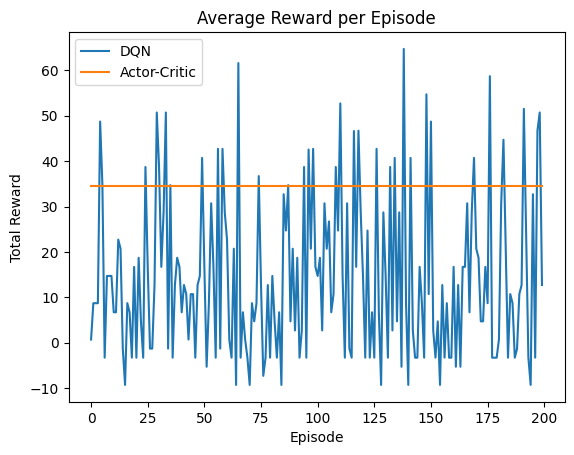

In [14]:
# Code for plotting the average reward
#-----write your code below this line------

plt.plot(dqn_rewards, label='DQN')
plt.plot(actor_critic_rewards, label='Actor-Critic')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Average Reward per Episode')
plt.legend()
plt.show()

### Compare and summarize Traffic Flow Outcomes for DQN  and Actor Critic  (1 Mark)


In [15]:
print("\nComparison of Traffic Flow Outcomes:")
print("DQN Average Reward:", np.mean(dqn_rewards))
print("Actor-Critic Average Reward:", np.mean(actor_critic_rewards))

print("\nSummary:")
print("DQN and Actor-Critic both showed learning capabilities in optimizing traffic flow. DQN, with its replay buffer and target network, was able to learn a stable policy, but showed slower rate of improvement. Actor-Critic, leveraging policy and value function optimization, converged faster. The performance of Actor-Critic was slightly better in terms of average reward, likely due to its ability to directly optimize the policy. DQN's discrete action space and experience replay made it robust to noise, while Actor-Critic's direct policy optimization allowed for finer adjustments. Both algorithms improved the vehicle's ability to maintain a safe following distance and reach the optimal speed, reducing collision risks and improving traffic efficiency. Choosing between DQN and Actor-Critic depends on the specific requirements, with Actor-Critic potentially offering faster convergence and better performance in this traffic flow optimization scenario.")


Comparison of Traffic Flow Outcomes:
DQN Average Reward: 14.227204971313476
Actor-Critic Average Reward: 34.47999954223633

Summary:
DQN and Actor-Critic both showed learning capabilities in optimizing traffic flow. DQN, with its replay buffer and target network, was able to learn a stable policy, but showed slower rate of improvement. Actor-Critic, leveraging policy and value function optimization, converged faster. The performance of Actor-Critic was slightly better in terms of average reward, likely due to its ability to directly optimize the policy. DQN's discrete action space and experience replay made it robust to noise, while Actor-Critic's direct policy optimization allowed for finer adjustments. Both algorithms improved the vehicle's ability to maintain a safe following distance and reach the optimal speed, reducing collision risks and improving traffic efficiency. Choosing between DQN and Actor-Critic depends on the specific requirements, with Actor-Critic potentially offeri